**Title:** *Churning Customers in a Telecoms Company*

**Description**: *Customer churn is a major problem and one of the most important concerns for large companies. This code will develop a churn prediction model that assists telecom operators in predicting customers who are most likely subject to churn, thus taking necessary actions to reduce this churn*

**Author:** *Faisal Alidu*

**Date:** *16th November 2023*

In [6]:
## Mounting on Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [103]:
## Import libraries
import keras
import utils
import pickle
import warnings
import numpy as np
import pandas as pd
from math import sqrt
import seaborn as sns
import tensorflow as tf
from keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import plotly.express as px ##  For visualization
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt ##  For visualization
from tensorflow.keras.layers import Input, Dense, Dropout
from sklearn.metrics import accuracy_score, roc_auc_score
from imblearn.over_sampling import SMOTE ## For oversampling
from sklearn.feature_selection import RFECV ## For feature selection
from sklearn.model_selection import StratifiedKFold ## For feature selection
from sklearn.linear_model import LogisticRegression ## For feature selection
warnings.simplefilter(action='ignore', category=Warning) ## Suppress warnings
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,roc_curve, recall_score,
                                  classification_report, f1_score, precision_recall_fscore_support)

In [104]:
## To display all the columns of the dataset:
pd.set_option('display.max_columns', None)

## Read the dataset
churn_dataset = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Intro to AI Folder/Assignment 3/CustomerChurn_dataset.csv')

In [ ]:
## View the dataset after reading
churn_dataset

In [ ]:
## View the datatypes for each columns in the dataset
churn_dataset.dtypes

In [ ]:
## View the number of rows and columns in the dataset
churn_dataset.shape

(7043, 21)

In [ ]:
## The describe function gives information about only numerical columns.
churn_dataset.describe()

In [ ]:
## The info() function gives some details like the total number of respective datatypes in the dataset
churn_dataset.info()

In [105]:
## Checking if there are Null Values in my dataset
churn_dataset.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

### **Making some changes to the churn_dataset**

In [106]:
## Renaming column: gender to Gender
churn_dataset.rename(columns={'gender':'Gender', }, inplace=True)

## Renaming column: tenure to Tenure
churn_dataset.rename(columns={'tenure':'Tenure', }, inplace=True)

In [107]:
## Convert the data type of the 'TotalCharges' column from object to numeric
churn_dataset['TotalCharges'] = churn_dataset['TotalCharges'].apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()

In [108]:
## Convert 'No internet service' to 'No' for the below mentioned columns
cols = ['OnlineBackup','StreamingMovies','DeviceProtection',
                'TechSupport','OnlineSecurity','StreamingTV']
for i in cols :
    churn_dataset[i]  = churn_dataset[i].replace({'No internet service' : 'No'})

## Convert 'No phone service' to 'No' for the below mentioned column
churn_dataset['MultipleLines'] = churn_dataset['MultipleLines'].replace({'No phone service' : 'No'})

In [109]:
## View the number of unique values of each column for the 7 columns which some of their unique values were changed
df = churn_dataset[['MultipleLines','OnlineBackup','StreamingMovies','DeviceProtection','TechSupport','OnlineSecurity','StreamingTV']]
print("\nUnique values:")
print(df.nunique())


Unique values:
MultipleLines       2
OnlineBackup        2
StreamingMovies     2
DeviceProtection    2
TechSupport         2
OnlineSecurity      2
StreamingTV         2
dtype: int64


In [110]:
## View the datatypes for each columns in the dataset
churn_dataset.dtypes

customerID           object
Gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
Tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [17]:
## View the dataset after making changes to these columns: Gender, Tenure and TotalCharges
churn_dataset.head()

,customerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [111]:
## Checking for the number of missing values in 'TotalCharges' column
churn_dataset['TotalCharges'].isnull().sum()

11

In [112]:
## Impute missing values for 'TotalCharges' column
churn_dataset['TotalCharges'] = churn_dataset['TotalCharges'].fillna(churn_dataset['TotalCharges'].median())

In [113]:
## Checking for the number of missing values in 'TotalCharges' column after imputing missing values
churn_dataset['TotalCharges'].isnull().sum()

0

In [114]:
## The info() function gives some details like the total number of respective datatypes in the dataset
churn_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   Tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


### **Exploratory Data Analysis**
*Even without building a fancy machine learning model, a simple data-driven analysis like this can help organizations understand why they are losing customers and what they can do about it. For instance, if the company realizes that most of their users who churn have not signed up for tech support, they can include this as a complimentary service in some of their future product offerings to prevent other customers from leaving.*

In [22]:
## An 0verview of the data
def data_overiew(df, message):
    print(f'{message}:')
    print('\n\nNumber of rows: ', df.shape[0])
    print("Number of features:", df.shape[1])
    print("\nData Features:")
    print(df.columns.tolist())
    print("\nMissing values:",df.isnull().sum().values.sum())
    print("\n\nUnique values:")
    print(df.nunique())

data_overiew(churn_dataset, 'Overview of the dataset')

Overview of the dataset:


Number of rows:  7043
Number of features: 21

Data Features:
['customerID', 'Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Missing values: 0


Unique values:
customerID          7043
Gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
Tenure                73
PhoneService           2
MultipleLines          2
InternetService        3
OnlineSecurity         2
OnlineBackup           2
DeviceProtection       2
TechSupport            2
StreamingTV            2
StreamingMovies        2
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64


In [23]:
## Count the number of customers in the dataset who have churned
churn_dataset["Churn"].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

In [24]:
## Exploring the target variable; Churn
target_var = churn_dataset["Churn"].value_counts().to_frame()
target_var = target_var.reset_index()
target_var = target_var.rename(columns={'index': 'Category'})
fig = px.pie(target_var, values='Churn', names='Category', color_discrete_sequence=[" blue", "red"], title='Distribution of Churn (in terms of Yes and No)')
fig.show()

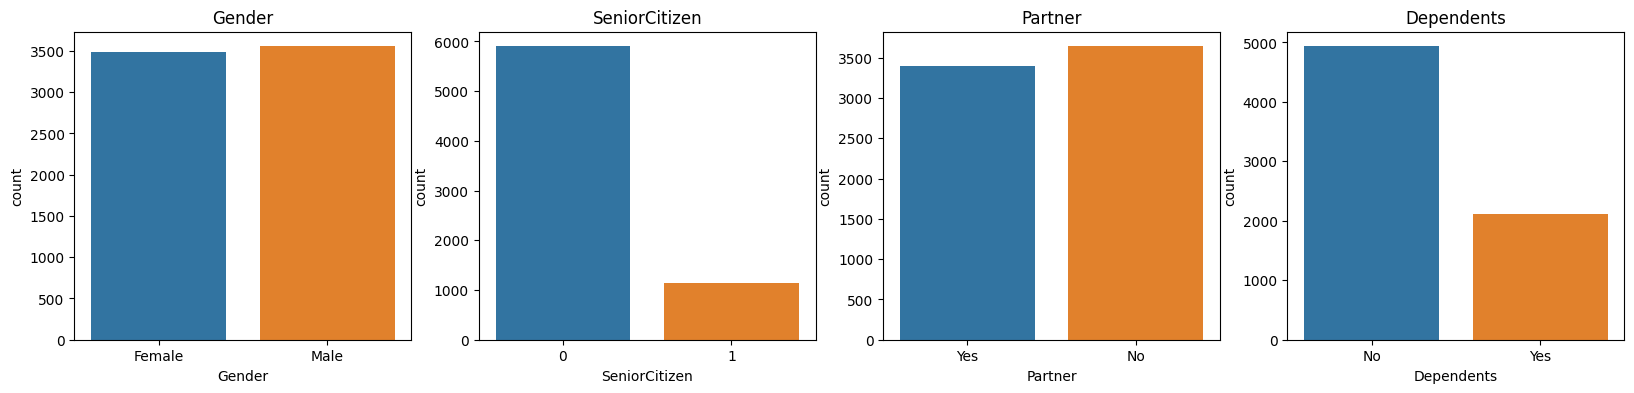

In [25]:
## Analyzing some demographic data points
some_cols = ['Gender','SeniorCitizen',"Partner","Dependents"]

plt.figure(figsize=(20,4))

for i, col in enumerate(some_cols):
    ax = plt.subplot(1, len(some_cols), i+1)
    sns.countplot(x=str(col), data=churn_dataset)
    ax.set_title(f"{col}")

*From the visual above, most customers in the dataset are younger
individuals without a dependent. There is an equal distribution
of user gender and nearly equal distribution of marital status*

<Axes: xlabel='Churn', ylabel='MonthlyCharges'>

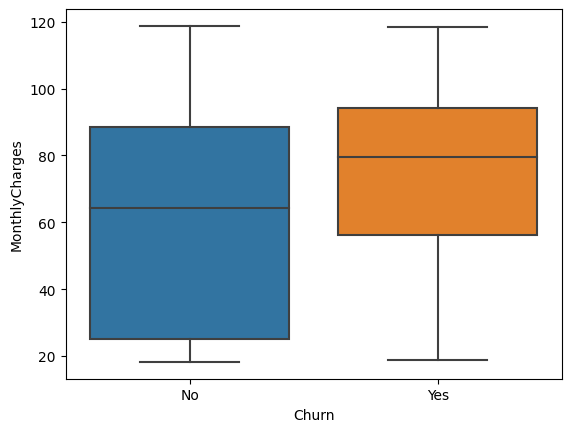

In [26]:
## Check the relationship between customer churn and costs/ Monthly Charges:
sns.boxplot(x='Churn', y='MonthlyCharges', data=churn_dataset)

*In the real world, users tend to unsubscribe to a service such as their mobile service provider and switch to a different brand if they find the monthly subscription cost too high.*

*From the visual above, the assumption above is true. Customers who churned have a higher median monthly charge than customers who renewed their subscription.*

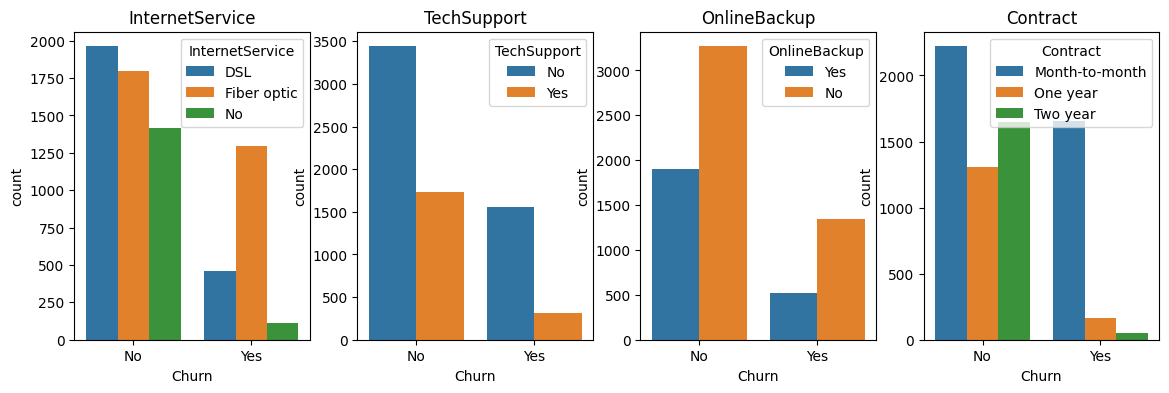

In [27]:
## Analyzing the relationship between customer churn and a few other categorical variables captured in the dataset
cols = ['InternetService',"TechSupport","OnlineBackup","Contract"]

plt.figure(figsize=(14,4))

for i, col in enumerate(cols):
    ax = plt.subplot(1, len(cols), i+1)
    sns.countplot(x ="Churn", hue = str(col), data = churn_dataset)
    ax.set_title(f"{col}")

**InternetService:** *It is clear from the visual above that customers who use fiber optic Internet churn more often than other users. This might be because fiber Internet is a more expensive service, or this provider doesn’t have good coverage.*

**TechSupport:** *Many users who churned did not sign up for tech support. This might mean that these customers did not receive any guidance on fixing technical issues and decided to stop using the service.*

**OnlineBackup:** *Many customers who had churned did not sign up for an online backup service for data storage.*

**Contract:** *Users who churned were almost always on a monthly contract. This makes sense, since these customers pay for the service on a monthly basis and can easily cancel their subscription before the next payment cycle.*

### **Data Preprocessing**

In [115]:
## Drop 'customerID' column since it is not useful for churn prediction as the feature is used for identification of customers.
selected_features = churn_dataset.drop(['customerID'], axis = 1)

In [ ]:
## View the selected_features dataset
selected_features

In [116]:
## View the number of rows and columns in the selected_features dataset
selected_features.shape

(7043, 20)

In [ ]:
## The info() function gives some details like the total number of respective datatypes
selected_features.info()

In [117]:
## Extract Categorical features from the selected features
selected_features_cat = selected_features.select_dtypes(np.object)

In [118]:
## View the categorical features of the selected_features dataset
selected_features_cat.columns

Index(['Gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'Churn'],
      dtype='object')

In [119]:
## View the datatype of the categorical features of selected features dataset. They are all objects
selected_features_cat.dtypes

Gender              object
Partner             object
Dependents          object
PhoneService        object
MultipleLines       object
InternetService     object
OnlineSecurity      object
OnlineBackup        object
DeviceProtection    object
TechSupport         object
StreamingTV         object
StreamingMovies     object
Contract            object
PaperlessBilling    object
PaymentMethod       object
Churn               object
dtype: object

In [120]:
## View the number of rows and columns of the categorical features of selected features dataset
selected_features_cat.shape

(7043, 16)

In [121]:
## Perform Label encoding on the categorical columns columns
label_encoder = LabelEncoder()
selected_features['Gender'] = label_encoder.fit_transform(selected_features['Gender'])
selected_features['Dependents'] = label_encoder.fit_transform(selected_features['Dependents'])
selected_features['Partner'] = label_encoder.fit_transform(selected_features['Partner'])
selected_features['PhoneService'] = label_encoder.fit_transform(selected_features['PhoneService'])
selected_features['MultipleLines'] = label_encoder.fit_transform(selected_features['MultipleLines'])
selected_features['InternetService'] = label_encoder.fit_transform(selected_features['InternetService'])
selected_features['OnlineSecurity'] = label_encoder.fit_transform(selected_features['OnlineSecurity'])
selected_features['OnlineBackup'] = label_encoder.fit_transform(selected_features['OnlineBackup'])
selected_features['DeviceProtection'] = label_encoder.fit_transform(selected_features['DeviceProtection'])
selected_features['TechSupport'] = label_encoder.fit_transform(selected_features['TechSupport'])
selected_features['StreamingTV'] = label_encoder.fit_transform(selected_features['StreamingTV'])
selected_features['StreamingMovies'] = label_encoder.fit_transform(selected_features['StreamingMovies'])
selected_features['Contract'] = label_encoder.fit_transform(selected_features['Contract'])
selected_features['PaperlessBilling'] = label_encoder.fit_transform(selected_features['PaperlessBilling'])
selected_features['PaymentMethod'] = label_encoder.fit_transform(selected_features['PaymentMethod'])
selected_features['Churn'] = label_encoder.fit_transform(selected_features['Churn'])

In [34]:
## View the 'Gender' column to confirm that the categorical column has been converted to numerical
selected_features['Gender'].head()

0    0
1    1
2    1
3    1
4    0
Name: Gender, dtype: int64

In [ ]:
## View the 'Dependents' column to confirm that the categorical column has been converted to numerical
selected_features['Dependents'].head()

In [ ]:
## View the 'Partner' column to confirm that the categorical column has been converted to numerical
selected_features['Partner'].head()

0    1
1    0
2    0
3    0
4    0
Name: Partner, dtype: int64

In [ ]:
## View the 'PhoneService' column to confirm that the categorical column has been converted to numerical
selected_features['PhoneService'].head()

0    0
1    1
2    1
3    0
4    1
Name: PhoneService, dtype: int64

In [ ]:
## View the 'MultipleLines' column to confirm that the categorical column has been converted to numerical
selected_features['MultipleLines'].head()

In [ ]:
## View the 'InternetService' column to confirm that the categorical column has been converted to numerical
selected_features['InternetService'].head()

In [ ]:
## View the 'OnlineSecurity' column to confirm that the categorical column has been converted to numerical
selected_features['OnlineSecurity'].head()

In [ ]:
## View the 'OnlineBackup' column to confirm that the categorical column has been converted to numerical
selected_features['OnlineBackup'].head()

0    1
1    0
2    1
3    0
4    0
Name: OnlineBackup, dtype: int64

In [ ]:
## View the 'DeviceProtection' column to confirm that the categorical column has been converted to numerical
selected_features['DeviceProtection'].head()

0    0
1    1
2    0
3    1
4    0
Name: DeviceProtection, dtype: int64

In [ ]:
## View the 'TechSupport' column to confirm that the categorical column has been converted to numerical
selected_features['TechSupport'].head()

0    0
1    0
2    0
3    1
4    0
Name: TechSupport, dtype: int64

In [35]:
## View the 'StreamingTV' column to confirm that the categorical column has been converted to numerical
selected_features['StreamingTV'].head()

0    0
1    0
2    0
3    0
4    0
Name: StreamingTV, dtype: int64

In [ ]:
## View the 'StreamingMovies' column to confirm that the categorical column has been converted to numerical
selected_features['StreamingMovies'].head()

In [ ]:
## View the 'Contract' column to confirm that the categorical column has been converted to numerical
selected_features['Contract'].head()

0    0
1    1
2    0
3    1
4    0
Name: Contract, dtype: int64

In [ ]:
## View the 'PaperlessBilling' column to confirm that the categorical column has been converted to numerical
selected_features['PaperlessBilling'].head()

0    1
1    0
2    1
3    0
4    1
Name: PaperlessBilling, dtype: int64

In [ ]:
## View the 'PaymentMethod' column to confirm that the categorical column has been converted to numerical
selected_features['PaymentMethod'].tail()

7038    3
7039    1
7040    2
7041    3
7042    0
Name: PaymentMethod, dtype: int64

In [122]:
## View the 'churn' column to confirm that the categorical column has been converted to numerical
selected_features['Churn'].head()

0    0
1    0
2    1
3    0
4    1
Name: Churn, dtype: int64

In [36]:
## View the selected_feature dataset after label encoding the numeric columns
selected_features.head()

,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,1,0,1,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,1,1,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,0,0,1,0,1,1,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


In [37]:
## View the number of rows and columns of the selected_features dataset after label encoding and scaling
selected_features.shape

(7043, 20)

In [38]:
## View the datatypes for each columns after categorical features have been converted into numeric
selected_features.dtypes

Gender                int64
SeniorCitizen         int64
Partner               int64
Dependents            int64
Tenure                int64
PhoneService          int64
MultipleLines         int64
InternetService       int64
OnlineSecurity        int64
OnlineBackup          int64
DeviceProtection      int64
TechSupport           int64
StreamingTV           int64
StreamingMovies       int64
Contract              int64
PaperlessBilling      int64
PaymentMethod         int64
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object

In [123]:
## View the column names of the selected_features dataset after categorical features have been converted into numeric
selected_features.columns

Index(['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

### Feature Selection

In [124]:
## Select the the independent (X) and dependent (y) variables from the selected_features dataset
y = selected_features['Churn']
X = selected_features.drop(['Churn'], axis = 1)

In [ ]:
X.head()

In [41]:
X.shape

(7043, 19)

In [ ]:
y.head()

In [125]:
## Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [126]:
## Feature selection to improve model building
log = LogisticRegression()
rfecv = RFECV(estimator=log, cv=StratifiedKFold(10, random_state=50, shuffle=True), scoring="accuracy")
rfecv.fit(X, y)

RFECV(cv=StratifiedKFold(n_splits=10, random_state=50, shuffle=True),
      estimator=LogisticRegression(), scoring='accuracy')

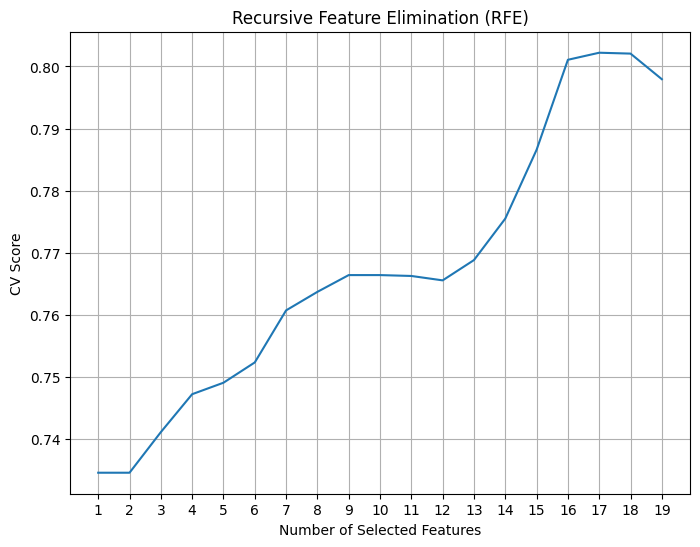

The optimal number of features: 17


In [127]:
## Recursive Feature Elimination (REF)
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.grid()
plt.xticks(range(1, X.shape[1]+1))
plt.xlabel("Number of Selected Features")
plt.ylabel("CV Score")
plt.title("Recursive Feature Elimination (RFE)")
plt.show()

print("The optimal number of features: {}".format(rfecv.n_features_))

In [128]:
## Saving dataframe with optimal features
X_rfe = X.iloc[:, rfecv.support_]

## Overview of the optimal features in comparison with the intial dataframe
print("\nInitial dimension of X: {}".format(X.shape))
print("\nInitial X column list:", X.columns.tolist())
print("\nDimension of X considering only the optimal features: {}".format(X_rfe.shape))
print("\nColumn list of X considering only the optimal features:", X_rfe.columns.tolist())


Initial dimension of X: (7043, 19)

Initial X column list: ['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']

Dimension of X considering only the optimal features: (7043, 17)

Column list of X considering only the optimal features: ['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'MonthlyCharges']


### **Training**

In [129]:
## The dataset containing optimal features
final_selected_features = X_rfe.columns.tolist()

In [130]:
final_selected_features

['Gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'Tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'MonthlyCharges']

In [131]:
## Select the the independent (X) and dependent (y) variables
X = selected_features[final_selected_features]
y = selected_features['Churn']


In [ ]:
X.head()

In [132]:
X.shape

(7043, 17)

In [ ]:
y.shape

(7043,)

In [133]:
## Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [134]:
## View the dimension of the training data and testing data
X_train.shape, y_test.shape, y_train.shape, X_test.shape


((5634, 17), (1409,), (5634,), (1409, 17))

### **Feature Scaling**

In [135]:
## Perform Feature Scaling on X_train and X_test
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [53]:
X_train.shape

(5634, 17)

In [137]:
X_test.shape

(1409, 17)

In [136]:
X_train

array([[-1.02516569e+00, -4.37749204e-01, -9.69578591e-01, ...,
         3.72908354e-01, -1.20000722e+00, -4.73723375e-04],
       [-1.02516569e+00, -4.37749204e-01, -9.69578591e-01, ...,
         1.57759050e+00,  8.33328321e-01,  1.07475386e+00],
       [ 9.75452077e-01, -4.37749204e-01,  1.03137591e+00, ...,
        -8.31773795e-01,  8.33328321e-01, -1.37649913e+00],
       ...,
       [ 9.75452077e-01, -4.37749204e-01,  1.03137591e+00, ...,
        -8.31773795e-01,  8.33328321e-01, -1.45294499e+00],
       [ 9.75452077e-01,  2.28441306e+00, -9.69578591e-01, ...,
        -8.31773795e-01,  8.33328321e-01,  1.14953785e+00],
       [ 9.75452077e-01, -4.37749204e-01, -9.69578591e-01, ...,
         3.72908354e-01, -1.20000722e+00, -1.49781538e+00]])

In [138]:
X_test

array([[-0.94946537, -0.44854601,  1.04724696, ..., -0.81439391,
         0.81577242, -1.31446753],
       [ 1.05322431, -0.44854601, -0.95488461, ..., -0.81439391,
         0.81577242, -1.29951212],
       [-0.94946537, -0.44854601,  1.04724696, ...,  1.54425156,
        -1.22583208, -1.49559418],
       ...,
       [ 1.05322431, -0.44854601,  1.04724696, ...,  0.36492882,
        -1.22583208, -1.47731534],
       [-0.94946537, -0.44854601,  1.04724696, ...,  1.54425156,
         0.81577242, -0.67803171],
       [ 1.05322431, -0.44854601, -0.95488461, ..., -0.81439391,
         0.81577242, -1.09678322]])

### **Oversampling**
*The dataset is imbalanced. Most customers in the dataset did not*
*churn - only 27% (approximately) of them did.This class imbalance problem*
*can lead to an underperforming machine learning model which is always*
*predicting a single outcome. We will use a technique called oversampling.*
*This is a process that involves randomly selecting samples from the*
*minority class and adding it to the training dataset. We are going to oversample the minority class until the number of data points are equal to*
*that of the majority class. We will oversample solely on the training dataset*

In [139]:
## Oversampling the training dataset
oversample = SMOTE(k_neighbors=5)
X_smote, y_smote = oversample.fit_resample(X_train, y_train)
X_train, y_train = X_smote, y_smote


In [140]:
## Check the number of samples in each class to ensure that they are equal:
##There should be 4,138 values in each class, which means that the training dataset is now balanced.
y_train.value_counts()

0    4138
1    4138
Name: Churn, dtype: int64

In [61]:
## View the dimension of the training data and testing data
X_train.shape, y_test.shape, y_train.shape, X_test.shape

((8276, 17), (1409,), (8276,), (1409, 17))

### **Model Creation**

In [141]:
## Define the architecture of the neural network using the Functional API
input_layer = Input(shape=(X_train.shape[1],))
hidden_layer_1 = Dense(64, activation='relu')(input_layer)
dropout_1 = Dropout(0.5)(hidden_layer_1)
hidden_layer_2 = Dense(32, activation='relu')(dropout_1)
output_layer = Dense(1, activation='sigmoid')(hidden_layer_2)

## Create the model
model = Model(inputs=input_layer, outputs=output_layer,  name="model")

## Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Train the model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

## Display the model summary
model.summary()

## Evaluate the model
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

## Calculate accuracy and AUC score
accuracy = accuracy_score(y_test, y_pred_binary)
auc_score = roc_auc_score(y_test, y_pred)

print(f"\nAccuracy: {accuracy}")
print(f"\nAUC Score: {auc_score}")


Epoch 1/10
130/130 [==============================] - 1s 4ms/step - loss: 0.5800 - accuracy: 0.6914 - val_loss: 0.5000 - val_accuracy: 0.7395
Epoch 2/10
130/130 [==============================] - 0s 3ms/step - loss: 0.5108 - accuracy: 0.7502 - val_loss: 0.4804 - val_accuracy: 0.7551
Epoch 3/10
130/130 [==============================] - 0s 3ms/step - loss: 0.4967 - accuracy: 0.7571 - val_loss: 0.4627 - val_accuracy: 0.7587
Epoch 4/10
130/130 [==============================] - 0s 3ms/step - loss: 0.4889 - accuracy: 0.7616 - val_loss: 0.4625 - val_accuracy: 0.7594
Epoch 5/10
130/130 [==============================] - 0s 3ms/step - loss: 0.4814 - accuracy: 0.7681 - val_loss: 0.4492 - val_accuracy: 0.7729
Epoch 6/10
130/130 [==============================] - 0s 3ms/step - loss: 0.4808 - accuracy: 0.7697 - val_loss: 0.4615 - val_accuracy: 0.7672
Epoch 7/10
130/130 [==============================] - 1s 5ms/step - loss: 0.4746 - accuracy: 0.7681 - val_loss: 0.4562 - val_accuracy: 0.7679
Epoch 

In [142]:
## Display the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 17)]              0         
                                                                 
 dense_27 (Dense)            (None, 64)                1152      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_28 (Dense)            (None, 32)                2080      
                                                                 
 dense_29 (Dense)            (None, 1)                 33        
                                                                 
Total params: 3265 (12.75 KB)
Trainable params: 3265 (12.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


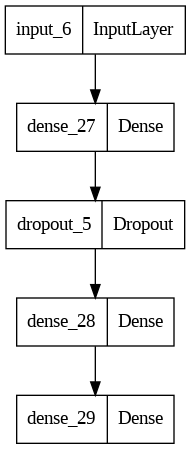

In [143]:
# visualize the architecture
plot_model(model)

In [144]:
## Evaluate the model's accuracy and calculate the AUC value.
y_pred = model.predict(X_test)
predictions = [np.round(value) for value in y_pred]

## Evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

45/45 [==============================] - 0s 2ms/step
Accuracy: 77.64%


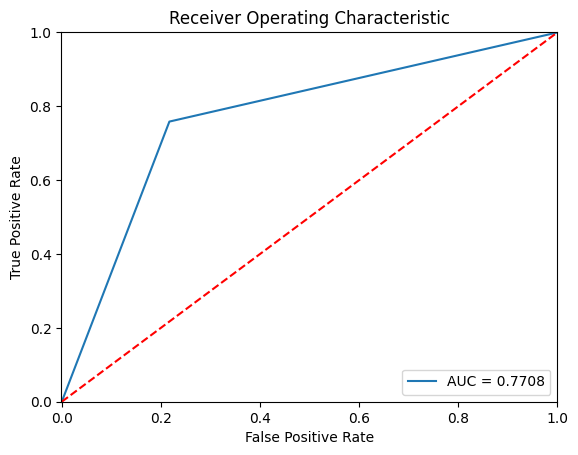

In [145]:
## Calculate the AUC


fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

In [146]:
## Calculating the confidence factor
cofidence_factor = 2.58 * sqrt( (accuracy * (1 - accuracy)) / y_test.shape[0])
cofidence_factor

0.02863631652798515

In [147]:
## Save the model
model = model.save('customer_churn.h5')

In [151]:
## load the saved model to use for prediction
model = load_model('customer_churn.h5')

In [152]:
y_pred = model.predict(X_test)
predictions = [np.round(value) for value in y_pred]

## Evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

45/45 [==============================] - 0s 2ms/step
Accuracy: 77.64%


In [150]:
print(tf.__version__)
print(keras.__version__)


2.14.0
2.14.0
